# Fault Tree Uncertainties


## Overview

This lecture puts elementary tools to work to approximate probability distributions of the annual failure rates of a system consisting of 
a number of critical parts.  

We'll use log normal distributions to approximate probability distributions of critical  component parts.

To  approximate the probability distribution of the **sum** of $n$ log normal probability distributions that describes the failure rate of the 
entire system, we'll compute the convolution of those $n$ log normal probability distributions.

We'll use the following concepts and tools:

* log normal distributions
* the convolution theorem that describes the probability distribution of the sum independent random variables
* fault tree analysis for approximating a failure rate of a multi-component system
* a hierarchical probability model for describing uncertain probabilities  
* Fourier transforms and inverse Fourier tranforms as efficient ways of computing convolutions of sequences
  
For more about Fourier transforms see this quantecon lecture [Circulant Matrices](https://python.quantecon.org/eig_circulant.html)
as well as these  lecture  [Covariance Stationary Processes](https://python-advanced.quantecon.org/arma.html) and [Estimation of Spectra](https://python-advanced.quantecon.org/estspec.html).




El-Shanawany, Ardron,  and Walker {cite}`Ardron_2018` and Greenfield and Sargent {cite}`Greenfield_Sargent_1993`  used some of the methods described here  to approximate probabilities of failures of safety systems in nuclear facilities.

These methods respond to some of the recommendations made by Apostolakis  {cite}`apostolakis1990` for constructing procedures for quantifying
uncertainty about the reliability of a safety system.

We'll start by bringing in some Python machinery.

In [1]:
!pip install tabulate

In [2]:
import numpy as np
from numpy import fft
import matplotlib.pyplot as plt
import scipy as sc
from scipy.signal import fftconvolve
from tabulate import tabulate
import time
%matplotlib inline

In [3]:
np.set_printoptions(precision=3, suppress=True)

<!-- #region -->


## Log normal distribution



If a random variable $x$ follows a normal distribution with mean $\mu$ and variance $\sigma^2$,
then the natural logarithm of $x$, say $y = \log(x)$, follows a **log normal distribution** with parameters $\mu, \sigma^2$.  

Notice that we said **parameters** and not **mean and variance** $\mu,\sigma^2$.

 * $\mu$ and $\sigma^2$ are the mean and variance of $x = \exp (y)$
 * they are **not** the mean and variance of $y$
 * instead, the  mean of $y$ is $e ^{\mu + \frac{1}{2} \sigma^2}$ and the variance of $y$ is $(e^{\sigma^2} - 1) e^{2 \mu + \sigma^2} $

A log normal  random variable $y$ is nonnegative. 
  

The density for a log normal random variate $y$ is

$$ f(y) = \frac{1}{y \sigma \sqrt{2 \pi}} \exp \left(  \frac{- (\log y - \mu)^2 }{2 \sigma^2} \right) $$

for $y \geq 0$.  


Important features of a log normal random variable are

$$
\begin{aligned}
 \textrm{mean:} & \quad e ^{\mu + \frac{1}{2} \sigma^2} \cr
 \textrm{variance:}  & \quad (e^{\sigma^2} - 1) e^{2 \mu + \sigma^2} \cr
  \textrm{median:} & \quad e^\mu \cr
 \textrm{mode:} & \quad e^{\mu - \sigma^2} \cr
 \textrm{.95 quantile:} & \quad e^{\mu + 1.645 \sigma} \cr
 \textrm{.95-.05 quantile ratio:}  & \quad e^{1.645 \sigma} \cr
 \end{aligned}
$$


Recall the following _stability_ property of two independent normally distributed random variables:

If $x_1$ is normal with mean $\mu_1$ and variance $\sigma_1^2$ and $x_2$ is independent of $x_1$ and normal with mean $\mu_2$ and variance $\sigma_2^2$, then $x_1 + x_2$ is normally distributed with
mean $\mu_1 + \mu_2$ and variance $\sigma_1^2 + \sigma_2^2$.


Independent log normal distributions have a different _stability_ property.

The **product** of  independent log normal random variables is also log normal.

   
In particular, if $y_1$ is log normal with parameters $(\mu_1, \sigma_1^2)$ and 
$y_2$ is log normal with parameters $(\mu_2, \sigma_2^2)$, then the product $y_1 y_2$ is log normal
with parameters $(\mu_1 + \mu_2, \sigma_1^2 + \sigma_2^2)$.

**Note:** While the product of two log normal distributions is log normal, the **sum** of two log normal distributions is **not** log normal.  

This observation sets the stage for challenge that confronts us in this lecture, namely, to approximate probability distributions of **sums** of independent log normal random variables.

To compute the probability distribution of the sum of two log normal distributions, we can use the following convolution property of a probability distribution that is a sum of independent random variables.

## The Convolution Property

Let $x$ be a random variable with probability density $f(x)$, where $x \in {\bf R}$.

Let $y$ be a random variable with probability density $g(y)$, where $y \in {\bf R}$.

Let $x$ and $y$ be independent random variables and let $z = x + y \in {\bf R}$.

Then the probability distribution of $z$ is 

$$ h(z) = (f * g)(z) \equiv \int_{-\infty}^\infty f (z) g(z - \tau) d \tau $$

where  $(f*g)$ denotes the **convolution** of the two functions $f$ and $g$.

If the random variables are both nonnegative, then the above formula specializes to

$$ h(z) = (f * g)(z) \equiv \int_{0}^\infty f (z) g(z - \tau) d \tau $$

Below, we'll use a discretized version of the preceding formula.  

In particular, we'll replace both $f$ and $g$ with discretized counterparts, normalized to sum to $1$ so that they are probability distributions.
 
  * by **discretized** we mean an equally spaced sampled version 

Then we'll use the following version of the above formula

$$ h_n = (f*g)_n = \sum_{m=0}^\infty f_m g_{n-m} , n \geq 0 $$

to compute a discretized version of the probability distribution of the sum of two random variables,
one with probability mass function $f$, the other with probability mass function $g$.    




<!-- #endregion -->

Before applying the convolution property to sums of log normal distributions, let's practice on some simple discrete distributions.

To take one  example, let's consider the following two probability distributions

$$ f_j = \textrm{Prob} (X = j), j = 0, 1 $$

and 

$$ g_j = \textrm{Prob} (Y = j ) , j = 0, 1, 2, 3 $$

and 

$$ h_j = \textrm{Prob} (Z \equiv X + Y = j) , j=0, 1, 2, 3, 4 $$

The convolution property tells us that

$$ h = f* g = g* f $$

Let's compute  an example using the `numpy.convolve` and `scipy.signal.fftconvolve`.

In [4]:
f = [.75, .25]
g = [0., .6,  0., .4]
h = np.convolve(f,g)
hf = fftconvolve(f,g)

print("f = ", f,  ", np.sum(f) = ", np.sum(f)) 
print("g = ", g, ", np.sum(g) = ", np.sum(g))
print("h = ", h, ", np.sum(h) = ", np.sum(h))
print("hf = ", hf, ",np.sum(hf) = ", np.sum(hf))

f =  [0.75, 0.25] , np.sum(f) =  1.0
g =  [0.0, 0.6, 0.0, 0.4] , np.sum(g) =  1.0
h =  [0.   0.45 0.15 0.3  0.1 ] , np.sum(h) =  1.0
hf =  [0.   0.45 0.15 0.3  0.1 ] ,np.sum(hf) =  1.0000000000000002


A little later we'll explain some advantages that come from using `scipy.signal.ftconvolve` rather than `numpy.convolve`.numpy program convolve.

They provide the same answers but `scipy.signal.ftconvolve` is much faster.

That's why we rely on it later in this lecture.


## Approximating Distributions

We'll construct an example to verify that  discretized distributions can do a good job of approximating  samples drawn from underlying
continuous distributions. 

We'll start by generating samples of size 25000 of three independent  log normal random variates as well as pairwise and triple-wise sums.

Then we'll plot  histograms and compare them with convolutions of appropriate discretized log normal distributions.

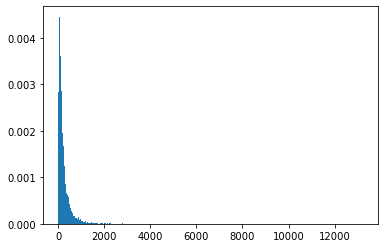

In [5]:
## create sums of two and three log normal random variates ssum2 = s1 + s2 and ssum3 = s1 + s2 + s3


mu1, sigma1 = 5., 1. # mean and standard deviation
s1 = np.random.lognormal(mu1, sigma1, 25000)

mu2, sigma2 = 5., 1. # mean and standard deviation
s2 = np.random.lognormal(mu2, sigma2, 25000)

mu3, sigma3 = 5., 1. # mean and standard deviation
s3 = np.random.lognormal(mu3, sigma3, 25000)

ssum2 = s1 + s2

ssum3 = s1 + s2 + s3

count, bins, ignored = plt.hist(s1, 1000, density=True, align='mid')



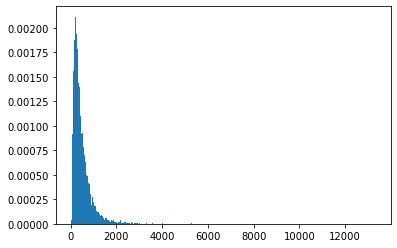

In [6]:
count, bins, ignored = plt.hist(ssum2, 1000, density=True, align='mid')

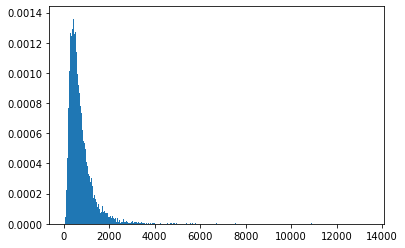

In [7]:
count, bins, ignored = plt.hist(ssum3, 1000, density=True, align='mid')

In [8]:
samp_mean2 = np.mean(s2)
pop_mean2 = np.exp(mu2+ (sigma2**2)/2)

pop_mean2, samp_mean2, mu2, sigma2

(2.4469193226422038e+02, 242.7059820205063, 5.0, 1.0)

Here are helper functions that create a discretized version of a log normal
probability density function.

In [9]:
def p_log_normal(x,μ,σ):
    p = 1 / (σ*x*np.sqrt(2*np.pi)) * np.exp(-1/2*((np.log(x) - μ)/σ)**2)
    return p

def pdf_seq(μ,σ,I,m):
    x = np.arange(1e-7,I,m)
    p_array = p_log_normal(x,μ,σ)
    p_array_norm = p_array/np.sum(p_array)
    return p_array,p_array_norm,x

<!-- #region -->
Now we shall set a grid length $I$ and a grid increment size $m =1$ for our discretizations.

**Note**: We set $I$ equal to a power of two because we want to be free to use a Fast Fourier Transform
to compute a convolution of two sequences (discrete distributions).


We recommend experimenting with different values of the power $p$ of 2.

Setting it to 15 rather than 12, for example, improves how well the discretized probability mass function approximates the original continuous probability density function being studied. 

<!-- #endregion -->

In [10]:
p=15
I = 2**p # Truncation value
m = .1 # increment size


/tmp/ipykernel_14930/2130497458.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  plt.plot(x[:np.int(NT)],p1[:np.int(NT)],label = '')


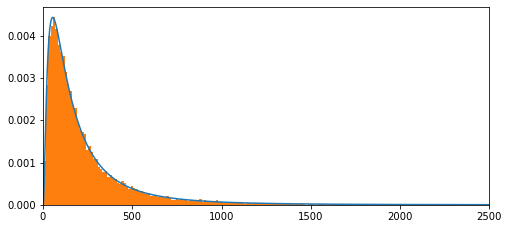

In [11]:
## Cell to check -- note what happens when don't normalize!  
## things match up without adjustment. Compare with above

p1,p1_norm,x = pdf_seq(mu1,sigma1,I,m)
## compute number of points to evaluate the probability mass function
NT = x.size

plt.figure(figsize = (8,8))
plt.subplot(2,1,1)
plt.plot(x[:np.int(NT)],p1[:np.int(NT)],label = '')
plt.xlim(0,2500)
count, bins, ignored = plt.hist(s1, 1000, density=True, align='mid')

plt.show()

In [12]:
# Compute mean from discretized pdf and compare with the theoretical value

mean= np.sum(np.multiply(x[:NT],p1_norm[:NT]))
meantheory = np.exp(mu1+.5*sigma1**2)
mean, meantheory

(2.446905989830291e+02, 244.69193226422038)

## Convolving Probability Mass Functions

Now let's use the convolution theorem to compute the probability distribution of a sum of the two log normal random variables we have parameterized above. 

We'll also compute the probability of a sum of three log normal distributions constructed above.


Before we do these things, we shall explain our choice of Python algorithm to compute a convolution
of two sequences.

Because the sequences that we convolve are long, we use the `scipy.signal.fftconvolve` function
rather than the numpy.convove function.  

These two functions give virtually equivalent answers but for long sequences `scipy.signal.fftconvolve`
is much faster.

The program `scipy.signal.fftconvolve` uses fast Fourier transforms and their inverses to calculate convolutions.

Let's define the Fourier transform and the inverse Fourier transform.

The **Fourier transform** of a sequence $\{x_t\}_{t=0}^{T-1}$ is  a sequence of complex numbers
$\{x(\omega_j)\}_{j=0}^{T-1}$ given by

$$
 x(\omega_j) = \sum_{t=0}^{T-1} x_t \exp(- i \omega_j t)
$$ (eq:ft1)

where $\omega_j = \frac{2 \pi j}{T}$ for $j=0, 1, \ldots, T-1$.

The **inverse Fourier transform** of the sequence $\{x(\omega_j)\}_{j=0}^{T-1}$ is

$$
 x_t = T^{-1} \sum_{j=0}^{T-1} x(\omega_j) \exp (i \omega_j t) 
$$ (eq:ift1)

The sequences $\{x_t\}_{t=0}^{T-1}$ and $\{x(\omega_j)\}_{j=0}^{T-1}$ contain the same information.

The pair of equations {eq}`eq:ft1` and {eq}`eq:ift1` tell how to recover one series from its Fourier partner.



The program `scipy.signal.fftconvolve` deploys  the theorem that  a convolution of two sequences $\{f_k\}, \{g_k\}$ can be computed in the following way:

-  Compute Fourier transforms $F(\omega), G(\omega)$ of the $\{f_k\}$ and $\{g_k\}$ sequences, respectively
-  Form the product $H (\omega) = F(\omega) G (\omega)$
- The convolution of $f * g$ is the inverse Fourier transform of $H(\omega)$


The **fast Fourier transform** and the associated **inverse fast Fourier transform** execute these
calculations very quickly.

This is the algorithm that   `scipy.signal.fftconvolve` uses.

Let's do a warmup calculation that compares the times taken by `numpy.convove` and `scipy.signal.fftconvolve`.

In [13]:

p1,p1_norm,x = pdf_seq(mu1,sigma1,I,m)
p2,p2_norm,x = pdf_seq(mu2,sigma2,I,m)
p3,p3_norm,x = pdf_seq(mu3,sigma3,I,m)

tic = time.perf_counter()

c1 = np.convolve(p1_norm,p2_norm)
c2 = np.convolve(c1,p3_norm)


toc = time.perf_counter()

tdiff1 = toc - tic

tic = time.perf_counter()

c1f = fftconvolve(p1_norm,p2_norm)
c2f = fftconvolve(c1f,p3_norm)
toc = time.perf_counter()

toc = time.perf_counter()

tdiff2 = toc - tic

print("time with np.convolve = ", tdiff1,  "; time with fftconvolve = ",  tdiff2)



time with np.convolve =  101.41922037700033 ; time with fftconvolve =  0.15787916799990853


The fast Fourier transform is two orders of magnitude faster than `numpy.convolve`


Now let's plot our computed probability mass function approximation  for the sum of two log normal random variables against the histogram of the sample that we formed above.

/tmp/ipykernel_14930/2364144025.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  plt.plot(x[:np.int(NT)],c1f[:np.int(NT)]/m,label = '')


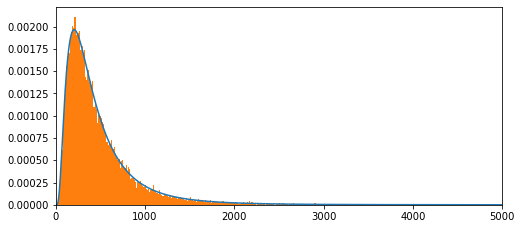

In [14]:
NT= np.size(x)

plt.figure(figsize = (8,8))
plt.subplot(2,1,1)
plt.plot(x[:np.int(NT)],c1f[:np.int(NT)]/m,label = '')
plt.xlim(0,5000)

count, bins, ignored = plt.hist(ssum2, 1000, density=True, align='mid')
# plt.plot(P2P3[:10000],label = 'FFT method',linestyle = '--')

plt.show()

/tmp/ipykernel_14930/3883904051.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  plt.plot(x[:np.int(NT)],c2f[:np.int(NT)]/m,label = '')


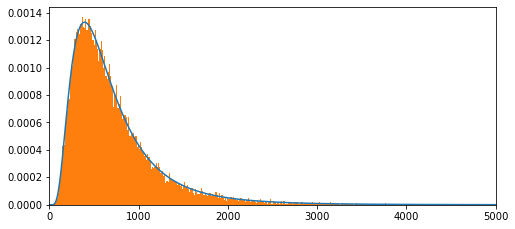

In [15]:
NT= np.size(x)
plt.figure(figsize = (8,8))
plt.subplot(2,1,1)
plt.plot(x[:np.int(NT)],c2f[:np.int(NT)]/m,label = '')
plt.xlim(0,5000)

count, bins, ignored = plt.hist(ssum3, 1000, density=True, align='mid')
# plt.plot(P2P3[:10000],label = 'FFT method',linestyle = '--')

plt.show()

In [16]:
## Let's compute the mean of the discretized pdf
mean= np.sum(np.multiply(x[:NT],c1f[:NT]))
# meantheory = np.exp(mu1+.5*sigma1**2)
mean, 2*meantheory

(489.38109740938546, 489.38386452844077)

In [17]:
## Let's compute the mean of the discretized pdf
mean= np.sum(np.multiply(x[:NT],c2f[:NT]))
# meantheory = np.exp(mu1+.5*sigma1**2)
mean, 3*meantheory

(734.0714863312252, 734.0757967926611)

<!-- #region -->
## Failure Tree Analysis

We shall soon apply the convolution theorem to compute the probability of a **top event** in a failure tree analysis.

Before applying the convolution theorem, we first describe the model that connects constituent events to the **top** end whose
failure rate we seek to quantify.

The model is an example of the widely used  **failure tree analysis** described by  El-Shanawany, Ardron,  and Walker {cite}`Ardron_2018`.

To construct the statistical model, we repeatedly use  what is called the **rare event approximation**.

We want to compute the probabilty of an event $A \cup B$. 

 * the union $A \cup B$ is the event that $A$ OR $B$ occurs

A law of probability tells us that  $A$ OR $B$ occurs with probability

$$ P(A \cup B) = P(A) + P(B) - P(A \cap B) $$

where the intersection $A \cap B$ is the event that $A$ **AND** $B$ both occur and the union $A \cup B$ is
the event that $A$ **OR** $B$ occurs.

If $A$ and $B$ are independent, then 

$$ P(A \cap B) = P(A) P(B)  $$

If $P(A)$ and $P(B)$ are both small, then $P(A) P(B)$ is even smaller.  

The **rare event approximation** is

$$ P(A \cup B) \approx P(A) + P(B)  $$

This approximation is widely used in evaluating system failures.


## Application 

A system has been designed with the feature a system  failure occurs when **any** of  $n$ critical  components  fails.

The failure probability $P(A_i)$  of each event $A_i$  is small.

We assume that failures of the components are statistically independent random variables.


We repeatedly apply a **rare event approximation** to obtain the following formula for the problem
of a system failure:

$$ P(F) \approx P(A_1) + P (A_2) + \cdots + P (A_n) $$

or 

$$ 
P(F) \approx \sum_{i=1}^n P (A_i) 
$$ (eq:probtop)

Probabilities for each event are recorded as failure rates per year.


## Failure Rates Unknown

Now we come to the problem that really interests us, following  {cite}`Ardron_2018` and Greenfield and Sargent 
 {cite}`Greenfield_Sargent_1993`  in the spirit of Apostolakis  {cite}`apostolakis1990`.  

The constituent probabilities or failure rates $P(A_i)$ are not known a priori and have to be estimated.  

We address this problem by specifying **probabilities of probabilities** that  capture one  notion of not knowing the constituent probabilities that are inputs into a failure tree analysis.


Thus, we assume that a system analyst is uncertain about  the failure rates $P(A_i), i =1, \ldots, n$ for components of a system.

The analyst copes with this situation by regarding the systems failure probability $P(F)$ and each of the component probabilities $P(A_i)$ as  random variables.

  * dispersions of the probability distribution of $P(A_i)$ characterizes the analyst's uncertainty about the failure probability $P(A_i)$

  * the dispersion of the implied probability distribution of $P(F)$ characterizes his uncertainty about the probability of a system's failure.
  
This leads to what is sometimes called a **hierarchical** model in which the analyst has  probabilities about the probabilities $P(A_i)$.

The analyst formalizes his uncertainty by assuming that 

 * the failure probability $P(A_i)$ is itself a log normal random variable with parameters $(\mu_i, \sigma_i)$.
 * failure rates $P(A_i)$ and $P(A_j)$ are statistically independent for all pairs with $i \neq j$.

The analyst  calibrates the parameters  $(\mu_i, \sigma_i)$ for the failure events $i = 1, \ldots, n$ by reading reliability studies in engineering papers that have studied historical failure rates of components that are as similar as possible to the components being used in the system under study. 

The analyst assumes that such  information about the observed dispersion of annual failure rates, or times to failure, can inform him of what to expect about parts' performances in his system.

The analyst  assumes that the random variables $P(A_i)$   are  statistically mutually independent.



The analyst wants to approximate a probability mass function and cumulative distribution function
of the systems failure probability $P(F)$.

  * We say probability mass function because of how we discretize each random variable, as described earlier.

The analyst calculates the probability mass function for the **top event** $F$, i.e., a **system failure**,  by repeatedly applying the convolution theorem to compute the probability distribution of a sum of independent log normal random variables, as described in equation
{eq}`eq:probtop`. 

<!-- #endregion -->

## Waste Hoist Failure Rate

We'll take close to a real world example by assuming that $n = 14$.

The example estimates the annual failure rate of a critical  hoist at a nuclear waste facility.

A regulatory agency wants the sytem to be designed in a way that makes the failure rate of the top event small with high probability.

This example is Design Option B-2 (Case I) described in Table 10 on page 27 of {cite}`Greenfield_Sargent_1993`.

The table describes parameters $\mu_i, \sigma_i$ for  fourteen log normal random variables that consist of  **seven pairs** of random variables that are identically and independently distributed.

 * Within a pair, parameters $\mu_i, \sigma_i$ are the same 

 * As described in table 10 of {cite}`Greenfield_Sargent_1993`  p. 27, parameters of log normal distributions for  the seven unique probabilities $P(A_i)$ have been calibrated to be the values in the following Python code:

In [18]:
mu1, sigma1 = 4.28, 1.1947
mu2, sigma2 = 3.39, 1.1947
mu3, sigma3 = 2.795, 1.1947
mu4, sigma4 = 2.717, 1.1947
mu5, sigma5 = 2.717, 1.1947
mu6, sigma6 = 1.444, 1.4632
mu7, sigma7 = -.040, 1.4632


**Note:** Because the failure rates are all very small,  log normal distributions with the
above parameter values actually describe $P(A_i)$ times $10^{-09}$.

So the probabilities that we'll put on the $x$ axis of the probability mass function and associated cumulative distribution function should be multiplied by $10^{-09}$


To extract a table that summarizes computed quantiles, we'll use a helper function

In [19]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

We compute the required thirteen convolutions in the following code.

(Please feel free to try different values of the power parameter $p$ that we use to set the number of points in our grid for constructing
the probability mass functions that discretize the continuous log normal distributions.)

We'll plot a counterpart to the cumulative distribution function (CDF) in  figure 5 on page 29 of {cite}`Greenfield_Sargent_1993` 
and we'll also present a counterpart to their Table 11 on page 28.

In [20]:
p=15
I = 2**p # Truncation value
m =  .05 # increment size




p1,p1_norm,x = pdf_seq(mu1,sigma1,I,m)
p2,p2_norm,x = pdf_seq(mu2,sigma2,I,m)
p3,p3_norm,x = pdf_seq(mu3,sigma3,I,m)
p4,p4_norm,x = pdf_seq(mu4,sigma4,I,m)
p5,p5_norm,x = pdf_seq(mu5,sigma5,I,m)
p6,p6_norm,x = pdf_seq(mu6,sigma6,I,m)
p7,p7_norm,x = pdf_seq(mu7,sigma7,I,m)
p8,p8_norm,x = pdf_seq(mu7,sigma7,I,m)
p9,p9_norm,x = pdf_seq(mu7,sigma7,I,m)
p10,p10_norm,x = pdf_seq(mu7,sigma7,I,m)
p11,p11_norm,x = pdf_seq(mu7,sigma7,I,m)
p12,p12_norm,x = pdf_seq(mu7,sigma7,I,m)
p13,p13_norm,x = pdf_seq(mu7,sigma7,I,m)
p14,p14_norm,x = pdf_seq(mu7,sigma7,I,m)

tic = time.perf_counter()

c1 = fftconvolve(p1_norm,p2_norm)
c2 = fftconvolve(c1,p3_norm)
c3 = fftconvolve(c2,p4_norm)
c4 = fftconvolve(c3,p5_norm)
c5 = fftconvolve(c4,p6_norm)
c6 = fftconvolve(c5,p7_norm)
c7 = fftconvolve(c6,p8_norm)
c8 = fftconvolve(c7,p9_norm)
c9 = fftconvolve(c8,p10_norm)
c10 = fftconvolve(c9,p11_norm)
c11 = fftconvolve(c10,p12_norm)
c12 = fftconvolve(c11,p13_norm)
c13 = fftconvolve(c12,p14_norm)

toc = time.perf_counter()

tdiff13 = toc - tic

print("time for 13 convolutions = ", tdiff13)


time for 13 convolutions =  8.01708439999993


/tmp/ipykernel_14930/3082528578.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Nx=np.int(1400)
/tmp/ipykernel_14930/3082528578.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details a

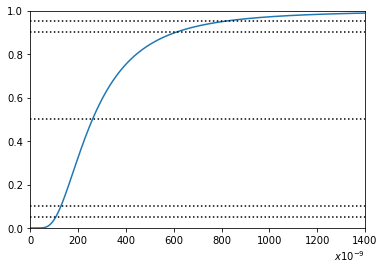

Percentile      x * 1e-9
------------  ----------
1%                 76.15
5%                106.5
10%               128.2
50%               260.55
66.5%             338.55
85%               509.4
90%               608.8
95%               807.6
99%              1470.2
99.78%           2474.85


In [21]:
d13 = np.cumsum(c13)
Nx=np.int(1400)
plt.figure()
plt.plot(x[0:np.int(Nx/m)],d13[0:np.int(Nx/m)])  # show Yad this -- I multiplied by m -- step size
plt.hlines(0.5,min(x),Nx,linestyles='dotted',colors = {'black'})
plt.hlines(0.9,min(x),Nx,linestyles='dotted',colors = {'black'})
plt.hlines(0.95,min(x),Nx,linestyles='dotted',colors = {'black'})
plt.hlines(0.1,min(x),Nx,linestyles='dotted',colors = {'black'})
plt.hlines(0.05,min(x),Nx,linestyles='dotted',colors = {'black'})
plt.ylim(0,1)
plt.xlim(0,Nx)
plt.xlabel("$x10^{-9}$",loc = "right")
plt.show()

x_1 = x[find_nearest(d13,0.01)]
x_5 = x[find_nearest(d13,0.05)]
x_10 = x[find_nearest(d13,0.1)]
x_50 = x[find_nearest(d13,0.50)]
x_66 = x[find_nearest(d13,0.665)]
x_85 = x[find_nearest(d13,0.85)]
x_90 = x[find_nearest(d13,0.90)]
x_95 = x[find_nearest(d13,0.95)]
x_99 = x[find_nearest(d13,0.99)] 
x_9978 = x[find_nearest(d13,0.9978)]

print(tabulate([
    ['1%',f"{x_1}"],
    ['5%',f"{x_5}"],
    ['10%',f"{x_10}"],
    ['50%',f"{x_50}"],
    ['66.5%',f"{x_66}"],    
    ['85%',f"{x_85}"],
    ['90%',f"{x_90}"],
    ['95%',f"{x_95}"],
    ['99%',f"{x_99}"],
    ['99.78%',f"{x_9978}"]],    
    headers = ['Percentile', 'x * 1e-9']))

The above table agrees closely with column 2 of  Table 11 on p. 28 of  of {cite}`Greenfield_Sargent_1993`. 

Discrepancies are probably due to slight differences in the number of digits retained in inputting $\mu_i, \sigma_i, i = 1, \ldots, 14$
and in the number of points deployed in the discretizations.